In [45]:
import numpy as np
import ast
import scipy   
import matplotlib.pyplot as plt
import cv2     
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.densenet import DenseNet201, preprocess_input
from keras.preprocessing import image    
from keras.models import Model   
import sys

def get_input_tensor(img_path):
    # loads the input image in a 4 D array ([1, 224, 224, 3]) 
    # and preprocess it
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

def get_Model():
    # define ResNet50 model
    # The ResNet_model has 2 outputs:
    #    - the output of the last layer (can be used to find the image label)
    #    - the output of the layer just before the Global Average Pooling Layer
    # (can be used to find which part of the image the network is look at)
    model = DenseNet201(weights='imagenet')
    last_layer_weights = model.layers[-1].get_weights()[0]
    # extract wanted output
    ResNet_model = Model(inputs=model.input, 
        outputs=(model.layers[-4].output, model.layers[-1].output)) 
    return ResNet_model, last_layer_weights

def get_class_activation_map(img_path, model, last_layer_weights):
    # (1) we predict the image label and we extract the output of the 
    # layer just before the Global Average Pooling Layer
    # (2) we upsample the features extracted to the image size
    # (3) we multiple the results by the layer weigh for the predicted label
    image=get_input_tensor(img_path)
    last_conv_output, pred_vec = model.predict(image)
    last_conv_output = np.squeeze(last_conv_output) 
    pred = np.argmax(pred_vec)
    print(image.shape)
    print((image.shape[1]/last_conv_output.shape[0], image.shape[2]/last_conv_output.shape[1], 1))   
    scale1=int(image.shape[1]/last_conv_output.shape[0])
    scale2=int(image.shape[2]/last_conv_output.shape[1])
    print(scale1,scale2)
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (scale1, scale2, 1), order=1)
    last_layer_weights = last_layer_weights[:, pred] 
    print((image.shape[1]*image.shape[2], last_layer_weights.shape[0]))
    final_output = np.dot(mat_for_mult.reshape((image.shape[1]*image.shape[2], last_layer_weights.shape[0])), last_layer_weights).reshape(224,224) 
    return final_output, pred



In [47]:
model, last_layer_weights = get_Model()
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_25 (ZeroPadding2 (None, 230, 230, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_25[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

(1, 224, 224, 3)
(32.0, 32.0, 1)
32 32
(50176, 1920)


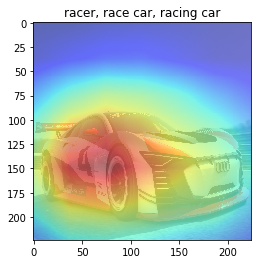

In [50]:
img_path = 'car2.jpg'
fig, ax = plt.subplots()
im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
# plot image
ax.imshow(im, alpha=0.5)
# get class activation map
CAM, pred = get_class_activation_map(img_path, model, last_layer_weights)
# plot class activation map
ax.imshow(CAM, cmap='jet', alpha=0.5)
# load the dictionary that identifies each ImageNet category to an index in the prediction vector
with open('imagenet1000_clsid_to_human.txt') as imagenet_classes_file:
    imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())
# obtain the predicted ImageNet category
ax.set_title(imagenet_classes_dict[pred])    
plt.show()